In [662]:
#!pip uninstall torch
!pip install torch==1.0.0
import torch
from torch.utils.data import DataLoader, Dataset

import torchgeometry as tgm
from torch.autograd import Variable

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (30,10)

import cv2
from PIL import Image, ImageSequence

from landmarks import detect_landmark
from perspective_projection_matrix import get_perspective, get_P
from pinhole_camera_model import facial_landmarks
from morphable_model import read_pca_model, get_face_point_cloud
from viewport_matrix import get_V
from changed_functions_file import main

import trimesh
from data_def import PCAModel, Mesh
from mesh_to_png import triangles, mean_tex

You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [691]:
#main()


In [702]:
#dataset with faces
class Faces(Dataset):
        def __init__(self, file = 'faces_sparser_sampling.gif', data_size= 150):
            im = Image.open('faces_sparser_sampling.gif')
            frames = np.array([np.array(frame.copy().convert('RGB').getdata(),dtype=np.uint8).reshape(frame.size[1],frame.size[0],3) for frame in ImageSequence.Iterator(im)])
            self.data = frames[:data_size]
            self.target = [torch.from_numpy(detect_landmark(img)).to(dtype = torch.float) for img in self.data]
            
        def __len__(self):
            return len(self.data)
    
        def __getitem__(self, idx):
            return (self.data[idx], self.target[idx])
batch_size=10
dataset = Faces()
dataloader = DataLoader(dataset,  batch_size = batch_size, shuffle = True, num_workers = 0, drop_last = True)


In [757]:
#rewritten to torch functions 
def get_face_point_cloud_torch(p, alpha, delta): 
    """
    Get face point cloud for given alpha and delta.

    :param p: PCA model received with read_pca_model()
    :param alpha: size 30
    :param delta: size 20
    :return: 3D point cloud of size [num_points x 3]
    """
    G_id = torch.from_numpy(p["mu_id"]) + torch.from_numpy(p["E_id"]) @ ( torch.from_numpy(p["sigma_id"]) * alpha)
    G_ex = torch.from_numpy(p["mu_ex"]) + torch.from_numpy(p["E_ex"]) @ ( torch.from_numpy(p["sigma_ex"]) * delta)
    return (G_id+G_ex).view((-1, 3))






def rotation_matrix(w):

    theta1, theta2, theta3 = w[0], w[1], w[2]
    
    zero = theta1.detach()*0
    one = zero.clone()+1
    
    cosx, sinx, cosy, siny, cosz, sinz = theta1.cos(), theta1.sin(), theta2.cos(), theta2.sin(), theta3.cos(),  theta3.sin()
    
    r_x = torch.stack([one, zero, zero,
                        zero,  cosx, sinx,
                        zero,  -sinx,  cosx]).view( 3, 3)
    
    r_y = torch.stack([cosy, zero,  -siny,
                        zero,  one, zero,
                        siny, zero,  cosy]).view( 3, 3)
    
    r_z = torch.stack([cosz, -sinz, zero,
                        sinz,  cosz, zero,
                        zero, zero,  one]).view( 3, 3)


    R = r_x @ r_y @ r_z
    return R


def facial_landmarks_torch(alpha, delta, w, t):
    """
    Construct facial landmarks from facial geometry latent parameters alpha, delta and object transformation w, t.

    :param alpha: array, 30dim
    :param delta: array, 20dim
    :param w: rotation angles around x,y, z. Given as list [theta_x, theta_y, theta_z].
    :param t: translation in x,y,z space. Given as list [translation_x, translation_y, translation_z]
    :return:
    """
    landmarks_idx = np.loadtxt("Landmarks68_model2017-1_face12_nomouth.anl", dtype=int)

    pca = read_pca_model()
    G = get_face_point_cloud_torch(pca, alpha, delta)[landmarks_idx].t()
    G_h = [G , torch.ones(G.shape[1]).view((1, -1))]
    G_h = torch.cat(G_h, dim=0)
    
    # get T matrix
    T = torch.eye(4)
    T[:3, :3] = rotation_matrix(w)#rotation_tensor(w, 1)#get_rotation_matrix_torch(w)  #torch.tensor([[1, 0, 0], [0, 1, 0], [0, 0, 1]])#
    T[:3, 3] = t
    
    # Get V and P matrices
    W = 172
    H = 162

    image_aspect_ratio = W / H
    angle = 10
    near = 30
    far = 3000

    right, left, top, bottom = get_perspective(image_aspect_ratio, angle, near, far)
    
    V = get_V(right, left, top, bottom)

    P = get_P(near, far, right, left, top, bottom)
    [V, P] = list(map(torch.from_numpy, [V, P]))
    V,P = V.to(dtype = torch.float32), P.to(dtype = torch.float32)
    n,f, t, b, r, l = near, far, top, bottom, right, left
    P = torch.Tensor([[(2 * n) / (t-b), 0, 0, 0],
                [0, (2 * n) / (t - b), 0, 0],
              [0, 0, -(f + n) / (f - n), -(2 * f * n) / (f - n)],
              [0, 0, -1, 0]])
    
   
    i =  V @ P @ T @ G_h

    # homo to cartesian
    i = i/i[3,:].clone()

    # two-dimensional
    return i[:2, :].t()



def normalise(landmarks, is_ground = False, values =None):
    
    max_x = torch.max(landmarks[:,0].detach())
    max_y = torch.max(landmarks[:,1].detach())
    min_x = torch.min(landmarks[:,0].detach())
    min_y = torch.min(landmarks[:,1].detach())

    
    scale=torch.sqrt((max_x-min_x).pow(2) + (max_y-min_y).pow(2))
    
    if values!=None:
        length, min_x, min_y = values
    landmarks[:,0] = (landmarks[:,0] - min_x)/scale 
    landmarks[:,1] = (landmarks[:,1] - min_y)/scale
    if is_ground:
        return landmarks, [scale, min_x, min_y]
    return landmarks



def denormalise(estimated_landmarks, target_landmarks, is_numpy = True):
    if is_numpy:
        estimated_landmarks, target_landmarks = torch.from_numpy(estimated_landmarks) ,  torch.form_numpy(target_landmarks)
    landmarks, values = normalise(target_landmarks, is_ground = True)
    
    estimated_landmarks = normalise(estimated_landmarks)
    estimated_landmarks[:,0] = estimated_landmarks[:,0]*values[0]+values[1]
    estimated_landmarks[:,1] = estimated_landmarks[:,1]*values[0]+values[2]
    estimated_landmarks = estimated_landmarks.detach().numpy()
    
    return estimated_landmarks
    

[0.0011]

Learning rate #0 is 0.0011
0 0.4503628611564636
10 0.4492335915565491
20 0.43767181038856506
30 0.4161026179790497
40 0.40158095955848694
50 0.39161041378974915
60 0.3834986090660095
70 0.37561553716659546
80 0.3678155541419983
90 0.36088335514068604
100 0.35527437925338745
110 0.35092493891716003
120 0.34698691964149475
130 0.33894044160842896
140 0.3320094347000122
149 0.3265792727470398
150 0.32601848244667053
160 0.3208751678466797
170 0.31655949354171753
180 0.3130469024181366
190 0.3102891743183136
LR decreases. New lr is 0.0011
200 0.3082364499568939
210 0.3068475127220154
220 0.30608537793159485
230 0.3059108853340149
240 0.3062889575958252
250 0.3071865439414978
LR decreases. New lr is 0.00011000000000000002
260 0.3085741102695465
270 0.30874723196029663
280 0.30893388390541077
290 0.3091270327568054
300 0.30932411551475525
310 0.30952349305152893
320 0.3097245395183563
330 0.3099280297756195
340 0.3101332485675812
350 0.3103395998477936
360 0.3105482757091522
370 0.

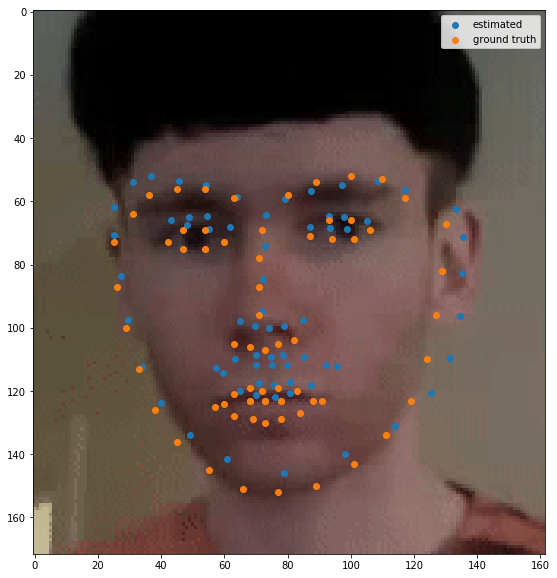

In [831]:
#set learning rates to collect 
lr_to_try = [0.0011]#np.linspace(.001, 0.003, 0)
print(lr_to_try)
results_total = []
image = cv2.imread('in.png')#
img =  dataset[0][0]#cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)##
#get ground truth landmarks
print()
target = torch.from_numpy(detect_landmark(img)).to(dtype = torch.float)
target, values = normalise(target, is_ground=True)
for iteration, lr in enumerate(lr_to_try):
    print("Learning rate #{} is {}".format(iteration, lr))
    results_intermiddeary = []
    #initialise variables to optimise
    #alpha = Variable(torch.from_numpy(np.random.uniform(-1,1, size=30)).to(dtype = torch.float), requires_grad=True)
    #delta = Variable(torch.from_numpy(np.random.uniform(-1,1, size=20)).to(dtype = torch.float), requires_grad=True)
    alpha = Variable(torch.zeros(30), requires_grad=True)
    delta = Variable(torch.zeros(20), requires_grad=True)
    
    w = Variable(torch.tensor([np.pi, 0.0, 0.0]), requires_grad=True)
    t = Variable(torch.tensor([0.0,0.0,-400.0]), requires_grad=True)
    #read an image
    
    #set optimisation parameters
    #lr = .003
    opt = torch.optim.Adam([alpha, delta, w, t], lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=1, gamma = 0.1)
    lambda_alpha = 5e-2
    lambda_delta = 5e-2
    #iterate
    for i in range(400):
        
        if  i in [200, 260]:
            scheduler.step()
            print("LR decreases. New lr is {}".format(opt.param_groups[0]['lr']))
    
            
        
        opt.zero_grad()
        #get predicted landmarks
        prediction_landmarks = facial_landmarks_torch(alpha, delta, w, t)
        prediction_landmarks = normalise(prediction_landmarks)
        
        #compute loss
        loss_lan = torch.sum(torch.norm((prediction_landmarks - target), dim=1).pow(2))
        loss_reg = lambda_alpha * (alpha.pow(2)).sum() + lambda_delta * (delta.pow(2)).sum()
        loss = loss_lan + loss_reg
        #backprop
        if i%10 ==0 or i ==149 :
            results_intermiddeary +=[loss.item()]
            print(i, loss.item())
        loss.backward()
        opt.step()
    print('Final iteration loss is: {}'.format(loss.item()))
    results_total+=[results_intermiddeary]
    #compute final landmarks
    

target = torch.from_numpy(detect_landmark(img)).to(dtype = torch.float)
print(target.shape)
target, values = normalise(target, is_ground = True)
target[:,0] = target[:,0]*values[0]+values[1]
target[:,1] = target[:,1]*values[0]+values[2]
target= target.detach().numpy()


estimated_landmarks = facial_landmarks_torch(alpha, delta, w, t)#.detach().numpy()
estimated_landmarks = normalise(estimated_landmarks)
estimated_landmarks[:,0] = estimated_landmarks[:,0]*values[0]+values[1]
estimated_landmarks[:,1] = estimated_landmarks[:,1]*values[0]+values[2]
estimated_landmarks = estimated_landmarks.detach().numpy()

plt.imshow(img)
plt.scatter(estimated_landmarks[:,0], estimated_landmarks[:,1], label = "estimated")
plt.scatter(target[:,0], target[:,1], label = "ground truth")
plt.legend()
plt.show()

In [849]:
np.save("best_params_small_magnitude.npy", np.array([alpha, delta, w, t]))

LR decreases. New lr is 0.035
0.8421165943145752
LR decreases. New lr is 0.035
0.7813124656677246
LR decreases. New lr is 0.035
0.768765926361084
LR decreases. New lr is 0.035
0.7675572633743286
LR decreases. New lr is 0.035
0.818256139755249
LR decreases. New lr is 0.035
0.7115950584411621
LR decreases. New lr is 0.035
0.7452701926231384
LR decreases. New lr is 0.035
0.7749559283256531
LR decreases. New lr is 0.035
0.7603811025619507
LR decreases. New lr is 0.035
0.7446037530899048
LR decreases. New lr is 0.035
0.8026206493377686
LR decreases. New lr is 0.035
0.836645245552063
LR decreases. New lr is 0.035
0.828457236289978
LR decreases. New lr is 0.035
0.8433220982551575
LR decreases. New lr is 0.035
0.8218852281570435
LR decreases. New lr is 0.035
0.8258379101753235
LR decreases. New lr is 0.035
0.8012897968292236
LR decreases. New lr is 0.035
0.7806985378265381
LR decreases. New lr is 0.035
0.7729151248931885
LR decreases. New lr is 0.035
0.7089154124259949
LR decreases. New lr is 

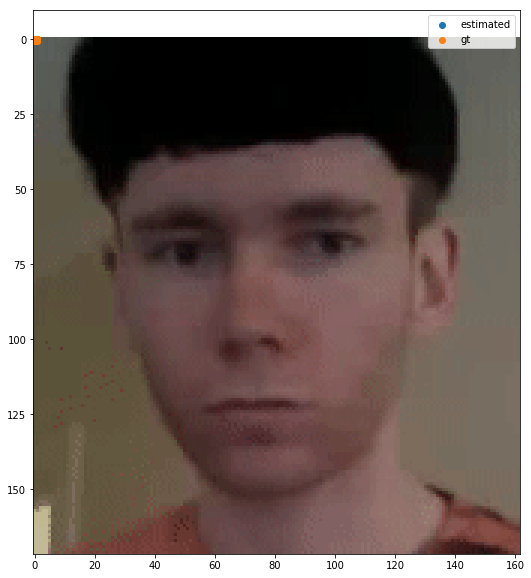

In [839]:
#optimisation of multiple frames
#initialise variables to optimise





#set optimisation parameters
lr = 0.035
lambda_alpha = 1e-2
lambda_delta = 1e-2



#stores each frame information
delta_s =  torch.ones((len(dataset),20))
alpha_s = torch.ones((len(dataset),30))
w_s = torch.ones((len(dataset),3))
t_s = torch.ones((len(dataset),3))
for i, (image, target) in enumerate(dataset):

    #params
    alpha = Variable(torch.zeros(30), requires_grad=True)
    delta = Variable(torch.zeros(20), requires_grad=True)
    w = Variable(torch.tensor([np.pi, 0.0, 0.0]), requires_grad=True)
    t = Variable(torch.tensor([0.0,0.0,-400.0]), requires_grad=True)
    #optimiser
    opt = torch.optim.Adam([alpha, delta, w, t], lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=1, gamma = 0.1)
    
    loss_list=[]
    for j in range(150):
        opt.zero_grad()
        if j in[70]:
            print("LR decreases. New lr is {}".format(opt.param_groups[0]['lr']))
        #get predicted landmarks
        target, values = normalise(target, is_ground=True)
        prediction_landmarks = facial_landmarks_torch(alpha, delta, w, t)
        prediction_landmarks = normalise(prediction_landmarks)
    
        
        #compute loss
        loss_lan = torch.sum(torch.norm((prediction_landmarks - target)).pow(2))
        loss_reg = lambda_alpha * (alpha.pow(2)).sum() + lambda_delta * (delta.pow(2)).sum()
        loss = loss_lan + loss_reg
        loss.backward()
        opt.step()
    print(loss.item())
    loss_list+=[loss.item()]
    #backprop
    #print(alpha_s.shape, alpha.shape)
    alpha_s[i] = alpha
    delta_s[i] = delta
    w_s[i] = w
    t_s[i] = t

print(i, mean_loss.item())

#compute final landmarks


#target = torch.from_numpy(detect_landmark(dataset[0][0])).to(dtype = torch.float)
target = dataset[0][1]
target, values = normalise(target, is_ground = True)
target[:,0] = target[:,0]*values[0]+values[1]
target[:,1] = target[:,1]*values[0]+values[2]
target= target.detach().numpy()


estimated_landmarks = facial_landmarks_torch(alpha, delta, w, t)#.detach().numpy()
estimated_landmarks = normalise(estimated_landmarks)
estimated_landmarks[:,0] = estimated_landmarks[:,0]*values[0]+values[1]
estimated_landmarks[:,1] = estimated_landmarks[:,1]*values[0]+values[2]
estimated_landmarks = estimated_landmarks.detach().numpy()

plt.imshow(dataset[0][0])
plt.scatter(estimated_landmarks[:,0], estimated_landmarks[:,1], label = "estimated")
plt.scatter(target[:,0], target[:,1], label = "gt")
plt.legend()
plt.show()

In [713]:
print(opt.param_groups[0]['lr'])

5.000000000000001e-07


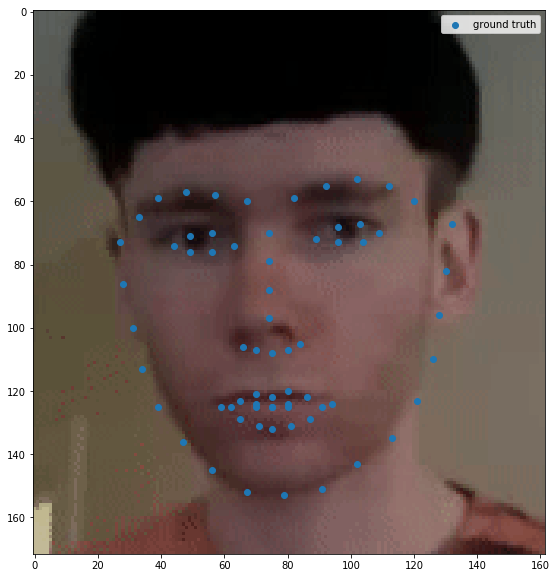

In [695]:
target = dataset[20][1]
target, values = normalise(target, is_ground = True)
target[:,0] = target[:,0]*values[0]+values[1]
target[:,1] = target[:,1]*values[0]+values[2]
target= target.detach().numpy()


estimated_landmarks = facial_landmarks_torch(alpha, delta, w, t)#.detach().numpy()
estimated_landmarks = normalise(estimated_landmarks)
estimated_landmarks[:,0] = estimated_landmarks[:,0]*values[0]+values[1]
estimated_landmarks[:,1] = estimated_landmarks[:,1]*values[0]+values[2]
estimated_landmarks = estimated_landmarks.detach().numpy()

plt.imshow(dataset[0][0])
#plt.scatter(estimated_landmarks[:,0], estimated_landmarks[:,1], label = "estimated")
plt.scatter(target[:,0], target[:,1], label = "ground truth")
plt.legend()
plt.show()
alpha_m, delta_m, w_m, t_m = alpha, delta, w, t

[tensor(145.), tensor(25.), tensor(52.)]


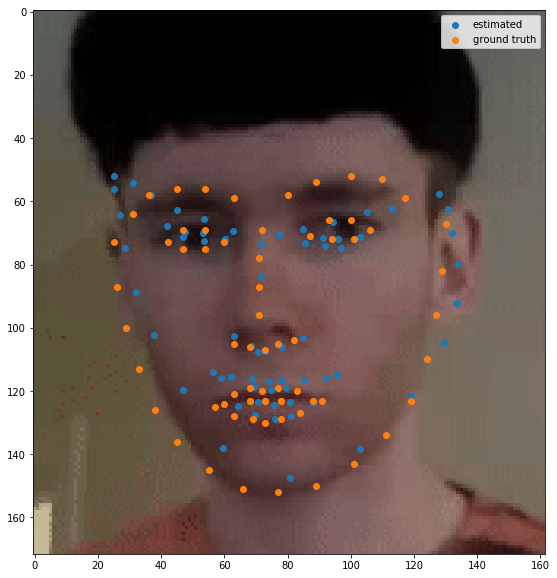

In [845]:
alpha_mean = alpha_s.mean(dim=0)
delta_mean = delta_s.mean(dim=0)

target = dataset[0][1]
target = torch.from_numpy(detect_landmark(dataset[0][0])).to(dtype = torch.float)
target, values = normalise(target, is_ground = True)
print(values)
target[:,0] = target[:,0]*values[0]+values[1]
target[:,1] = target[:,1]*values[0]+values[2]
target= target.detach().numpy()


estimated_landmarks = facial_landmarks_torch(alpha_mean, delta_mean, w_s[0], t_s[0])#.detach().numpy()
estimated_landmarks = normalise(estimated_landmarks)
estimated_landmarks[:,0] = estimated_landmarks[:,0]*values[0]+values[1]
estimated_landmarks[:,1] = estimated_landmarks[:,1]*values[0]+values[2]
estimated_landmarks = estimated_landmarks.detach().numpy()

plt.imshow(dataset[0][0])
plt.scatter(estimated_landmarks[:,0], estimated_landmarks[:,1], label = "estimated")
plt.scatter(target[:,0], target[:,1], label = "ground truth")
plt.legend()
plt.show()
#alpha_m, delta_m, w_m, t_m = alpha, delta, w, t

In [848]:
np.save("params_for_each_frame.npy", np.array([alpha_mean, delta_mean, w_s, t_s]))